In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark import SparkConf, SparkContext



spark = SparkSession.builder.master('local[4]').config('spark.driver.memory', '8g').getOrCreate()

In [ ]:
import os
from pyspark.sql.functions import split, element_at, explode, map_values, array_min, broadcast, map_from_entries, arrays_zip, array_contains, monotonically_increasing_id, array_distinct, transform, arrays_zip, size, slice, collect_list, first, map_from_arrays
from pyspark.sql.types import LongType, ArrayType, IntegerType, MapType

class CorpusLoader:

    def __init__(self, root_path, spark):
        self.__root_path = root_path
        self.__spark = spark

    def load(self):
        self.__array_df = self.__load_or_create_parquet('array.parquet', self.__create_array_df)
        self.__token_df = self.__load_or_create_parquet('token.parquet', self.__create_token_df)
        self.__contains_df = self.__load_or_create_parquet('contains.parquet', self.__create_contains_df)
        self.__data_df = self.__load_or_create_parquet('data.parquet', self.__create_data_df)

    def __load_or_create_parquet(self, name, create_function):
        parquet_path = os.path.join(os.path.join(self.__root_path, 'parquets'), name)
        
        if not os.path.exists(parquet_path):
            print(f'File "{name}" not found. \n\t -- Creating "{name}" ...')
            
            df = create_function()
            df.write.parquet(parquet_path)

            print('\t -- Done.')

        print(f'Loading "{name}" ...')
        return self.__spark.read.parquet(parquet_path)

    def __create_token_df(self):
        one_gram_path = os.path.join(self.__root_path, '1')

        one_gram_df = spark.read.csv(one_gram_path, sep='\n', quote="").withColumnRenamed('_c0', 'Input')
        token_df = one_gram_df \
                .select(split('Input', '\t').alias('SplitInput')) \
                .select(element_at('SplitInput', 1).alias('Tokens')) \
                .select(explode(split('Tokens', ' ')).alias('Token')) \
                .orderBy('Token') \
                .withColumn('TokenId', monotonically_increasing_id()) 
        
        return token_df

    def __create_array_df(self):
        n_gram_directories = [os.path.join(self.__root_path, x) for x in os.listdir(self.__root_path) if x.isdigit()]
        
        input_df = None

        for path in n_gram_directories:
            new_input_df = spark.read.csv(path, sep='\n', quote="").withColumnRenamed('_c0', 'Input')
            
            if input_df is None:
                input_df = new_input_df
            else:
                input_df = input_df.union(new_input_df)

        split_df = input_df \
                    .select(split('Input', '\t').alias('SplitInput')) \
                    .select(element_at('SplitInput', 1).alias('Tokens'),
                            slice('SplitInput', 2, size('SplitInput')).alias('Data')) \
                    .select(split('Tokens', ' ').alias('Tokens'), 'Data')

        array_df = split_df.select('Tokens', transform('Data', lambda d: split(d, ',')).alias('Data')) \
                    .select('Tokens', transform('Data', lambda x: x[0].cast(IntegerType())).alias('Years'),
                            transform('Data', lambda x: x[1].cast(LongType())).alias('Frequency'),
                            transform('Data', lambda x: x[2].cast(LongType())).alias('BookFrequency')) \
                    .withColumn('NgramId', monotonically_increasing_id())

        return array_df

    def __create_contains_df(self):
        n_gram_df = self.__array_df

        n_gram_to_token_id_df = n_gram_df.select('NgramId', 'Tokens') \
                .select(explode('Tokens').alias('Token'), 'NgramId') \
                .join(self.__token_df, on='Token') \
                .groupBy('NgramId').agg(collect_list('TokenId').alias('TokenIds'))
        print(n_gram_to_token_id_df.count())

        contains_df = n_gram_to_token_id_df.select('NgramId', 'TokenIds') \
            .withColumn('IndexArray', transform('TokenIds', lambda x, i: i)) \
            .select('NgramId', arrays_zip('IndexArray', 'TokenIds').alias('TokenIds')) \
            .select('NgramId', explode('TokenIds').alias('TokenId')) \
            .select('NgramId', 'TokenId.IndexArray', 'TokenId.TokenIds') \
            .withColumnsRenamed({'IndexArray': 'Position', 'TokenIds': 'TokenId'}) \
            .orderBy('NgramId')
        print(contains_df.count())

        return contains_df

    ## This horrific arrays to list of structs to map construct is required, because map_from_arrays zeroes everything out.
    def __create_data_df(self):
        data_df = self.__array_df.select('NgramId', 'Years', 'Frequency', 'BookFrequency')
        data_df = data_df.withColumn('FrequencyStructs', arrays_zip('Years', 'Frequency'))
        data_df = data_df.withColumn('BookFrequencyStructs', arrays_zip('Years', 'BookFrequency'))
        data_df = data_df.withColumn('FrequencyMap', map_from_entries('FrequencyStructs'))
        data_df = data_df.withColumn('BookFrequencyMap', map_from_entries('BookFrequencyStructs'))
        data_df = data_df.select('NgramId', 'FrequencyMap', 'BookFrequencyMap')

        data_df.printSchema()
        
        return data_df.withColumnsRenamed({'FrequencyMap': 'Frequency', 'BookFrequencyMap': 'BookFrequency'})

In [ ]:
cl = CorpusLoader('C:/Users/bincl/BA-Thesis/Dataset/parquets_corpus/', spark)

cl.load()

+------------+----+---------+------------+-----+----------+------------+-----+----------+
|     NgramId|Year|Frequency|    NgramId2|Year2|Frequency2|    NgramId3|Year3|Frequency3|
+------------+----+---------+------------+-----+----------+------------+-----+----------+
|661424963584|1800|        1|661424963585| 1800|         0|661424963586| 1800|         1|
|661424963584|1801|        0|661424963585| 1801|         0|661424963586| 1801|         0|
|661424963584|1802|        0|661424963585| 1802|         0|661424963586| 1802|         1|
|661424963584|1803|        0|661424963585| 1803|         0|661424963586| 1803|         2|
|661424963584|1804|        0|661424963585| 1804|         0|661424963586| 1804|         2|
|661424963584|1805|        0|661424963585| 1805|         0|661424963586| 1805|         2|
|661424963584|1806|        0|661424963585| 1806|         0|661424963586| 1806|         4|
|661424963584|1807|        0|661424963585| 1807|         0|661424963586| 1807|         5|
|661424963

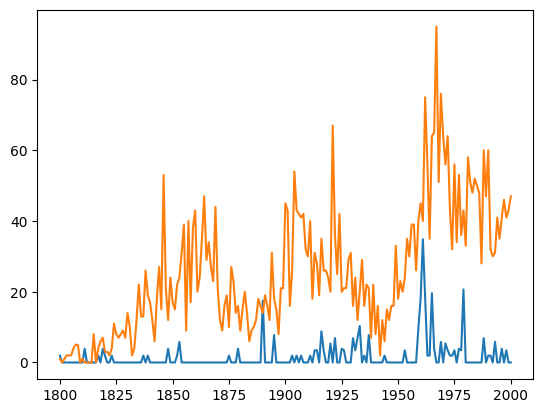

In [4]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import map_entries, explode, when, col, lit, collect_list
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import Row

from matplotlib import pyplot as plt

df = cl._CorpusLoader__data_df.select('NgramId', 'Frequency').limit(3)
# Create a DataFrame from the list of Row objects
year_df = spark.range(1800, 2001).toDF("id").withColumn("Year", col("id").cast(IntegerType())).select("Year")
#year_df = spark.createDataFrame(list(range(1800, 2001)), schema=IntegerType())

df = df.join(year_df).withColumnRenamed('value', 'Year')
df.printSchema()
df = df.withColumn("TrueFreq", when(col("Frequency").getItem(df.Year).isNotNull(),col("Frequency").getItem(df.Year)).otherwise(lit(0)))
df = df.select('NgramId', 'Year', 'TrueFreq').withColumnRenamed('TrueFreq', 'Frequency')
print(df.count())
df2 = df.withColumnRenamed('NgramId', 'NgramId2').withColumnRenamed('Frequency', 'Frequency2').withColumnRenamed('Year', 'Year2')
df3 = df.withColumnRenamed('NgramId', 'NgramId3').withColumnRenamed('Frequency', 'Frequency3').withColumnRenamed('Year', 'Year3')
df = df.join(df2, on=(df.Year == df2.Year2) & (df.NgramId < df2.NgramId2)).orderBy('NgramId', 'NgramId2', 'Year')
print(df.count())
df = df.join(df3, on=(df.Year == df3.Year3) & (df.NgramId2 < df3.NgramId3) & (df.NgramId < df3.NgramId3)).orderBy('NgramId', 'NgramId2', 'NgramId3', 'Year')
print(df.count())

df.show()

vectorAssembler = VectorAssembler(inputCols = ['Frequency', 'Frequency2'], outputCol='features')
df_test = vectorAssembler.transform(df)

lr = LinearRegression(featuresCol = 'features', labelCol='Frequency3', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(df_test)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

coefs = lr_model.coefficients
cols = df_test.select('Frequency', 'Frequency2', 'Frequency3').collect()
xs = range(1800, 2001)
ys = [(x.Frequency * coefs[0] + x.Frequency2 * coefs[1], x.Frequency3) for x in cols]

plt.plot(xs, ys)
plt.show()

In [5]:
import pandas as pd
import statsmodels.api as sm
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

group_column = 'NgramId'
intercept = "ic"
y_column = 'Frequency'
x_columns = ['Frequency2', 'Frequency3']
schema = StructType([StructField('id', IntegerType(), True), StructField('x1', DoubleType(), False), StructField('x2', DoubleType(), False),StructField('ic',  DoubleType(), True)])
#schema = df2.select(group_column, *x_columns).schema
print(schema)

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
# Input/output are both a pandas.DataFrame
def ols(pdf):
    group_key = pdf[group_column].iloc[0]
    y = pdf[y_column]
    X = pdf[x_columns]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return pd.DataFrame([[group_key] + [model.params[i] for i in x_columns] + [model.params[-1]]], columns=[group_column] + x_columns + [intercept])

df2.show()
beta = df2.groupby(group_column).apply(ols)
print(beta.count())
beta.show()

StructType([StructField('id', IntegerType(), True), StructField('x1', DoubleType(), False), StructField('x2', DoubleType(), False), StructField('ic', DoubleType(), True)])
+------------+-----+----------+
|    NgramId2|Year2|Frequency2|
+------------+-----+----------+
|661424963584| 1800|         1|
|661424963585| 1800|         0|
|661424963586| 1800|         1|
|661424963584| 1801|         0|
|661424963585| 1801|         0|
|661424963586| 1801|         0|
|661424963584| 1802|         0|
|661424963585| 1802|         0|
|661424963586| 1802|         1|
|661424963584| 1803|         0|
|661424963585| 1803|         0|
|661424963586| 1803|         2|
|661424963584| 1804|         0|
|661424963585| 1804|         0|
|661424963586| 1804|         2|
|661424963584| 1805|         0|
|661424963585| 1805|         0|
|661424963586| 1805|         2|
|661424963584| 1806|         0|
|661424963585| 1806|         0|
+------------+-----+----------+
only showing top 20 rows



c:\Users\bincl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
Traceback (most recent call last):
  File "c:\Users\bincl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\serializers.py", line 458, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\bincl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\cloudpickle\cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "c:\Users\bincl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\cloudpickle\cloudpickle_fast.py", line 602, in dump
    return Pickler.dump(self, obj)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\bincl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\c

PicklingError: Could not serialize object: IndexError: tuple index out of range